# Handwritten Digit Recognition (MNIST Dataset)
Modified National Institute of Standards and Technology database (MNIST dataset) is a large dataset of handwritten digits which is widely used in image processing and machine learning. The set of images in the MNIST database is a combination of two of NIST's databases: Special Database 1 and Special Database 3. Special Database 1 and Special Database 3 consist of digits written by high school students and employees of the United States Census Bureau, respectively.

## About the notebook
* In this notebook, I have covered the necessary steps to approach any Machine Learning Classification Problem.
* Included Image Visualization for better understanding.
* Quick Links to the functions I have used to explore it in depth.
* Basic techniques such as Confusion Matrix, Image Augmentation, etc.
* I have also compared the results of Model without using CNN and CNN.

## Task
The task is to classify the images in 10 class, i.e., [0-9], inclusively.

## Required Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle

%matplotlib inline

Using TensorFlow backend.


## About Dataset

[MNIST dataset](https://www.kaggle.com/c/digit-recognizer/data) has the following features:

* Dataset size 60,000 samples of handwritten images.
* The size of each image is 28x28 pixels.
* Each image has only 1 color channel, i.e., grayscale image.
* Each pixel has value in the range of [0,255] where 0 represents black, and 255 represents white.
* Each image has labeled from 0-9.

## Loading train.csv
This will loads the data from Kaggle dataset train.csv into a Dataframe. As file type is CSV, I am loading it using read_csv of pandas. Then using NumPy for random permutation of the training dataset. I am using seed to regenerate the same permutation every time. Change seed value to get different permutation.

In [2]:
np.random.seed(1)
df_train = pd.read_csv('datasets/train_mnist.csv')
df_train = df_train.iloc[np.random.permutation(len(df_train))]

In [3]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29633,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36369,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16624,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

Training set has 42,000 images. And has 785 columns, 1st coloumn is label for the image and rest 784 are the pixel values.
<b> Remember it is flattened. I will reshape it latter. </b>

## Preparing Training and Validation data
<b>It requires a few steps:</b>

* Assuming the validation set size. I am taking it 10% of the training set.
* Splitting training set into a training set (90% original training set) and validation set (10% original training set) from the training dataset.
* Reshaping both sets into (sample size,28,28,1) where sample size represents the size of the train or validation set.
* Splitting the labels for both training set and validation set.
Using df.iloc of pandas for slicing the data frame(read more link below), then converting into NumPy array and finally reshaping NumPy array in required shape.

In [5]:
sample_size = df_train.shape[0]
validation_size = int(df_train.shape[0] * 0.1)

#train_x and train_y
train_x = np.asarray(df_train.iloc[:sample_size - validation_size, 1:]).reshape([sample_size-validation_size, 28, 28, 1])
train_y = np.asarray(df_train.iloc[:sample_size - validation_size, 0]).reshape([sample_size - validation_size, 1])

#val_x and val_y
val_x = np.asarray(df_train.iloc[sample_size - validation_size:, 1:]).reshape([validation_size, 28, 28, 1])
val_y = np.asarray(df_train.iloc[sample_size - validation_size:, 0]).reshape([validation_size, 1])

In [6]:
train_x.shape, train_y.shape

((37800, 28, 28, 1), (37800, 1))

In [7]:
val_x.shape, val_y.shape

((4200, 28, 28, 1), (4200, 1))

## Loading test.csv
This will load the test.csv. It has 18,000 images and no label is there. Prediction need to be done on these images. After loading converting the data in form of numpy array and reshaping it.

In [8]:
df_test = pd.read_csv("datasets/test_mnist.csv")

test_x = np.asarray(df_test.iloc[:, :]).reshape(-1, 28, 28, 1)

In [9]:
test_x.shape

(28000, 28, 28, 1)

## Normalize Pixel Data
Each pixel values lies between [0,255]. This value range is too high and it will be difficult for any model to learn. The best approach is normalize the data. In this case, as the pixel value is in the known range it sufficient to scale the pixel values in range [0,1] by simply dividing the array by 255.

In [10]:
# convirting pixel values in range [0,1]
train_x = train_x / 255
val_x = val_x / 255
test_x = test_x / 255

In [11]:
counts = df_train.iloc[:sample_size - validation_size, :].groupby('label')['label'].count()
counts

label
0    3726
1    4202
2    3758
3    3888
4    3655
5    3415
6    3746
7    3949
8    3665
9    3796
Name: label, dtype: int64

## Visualize Digits dataset
The first and fundamental thing to check is the frequency of the classes in the dataset, as the balanced dataset is always good to start. But this is not always true, and there are several supervised learning tasks in which the classes are not balanced, also in case of anomaly detection, there is a large difference between the positive and negative class. But that is out of the scope of this notebook.

In [12]:
def frequency_plot(counts, title):
    f = plt.figure(figsize=(10, 6))
    f.add_subplot(111)

    plt.bar(counts.index, counts.values, width=0.8, color='red')
    for i in counts.index:
        plt.text(i, counts.values[i]+5, str(counts.values[i]), horizontalalignment='center', fontsize=14)

    plt.tick_params(labelsize=14)
    plt.xticks(counts.index)
    plt.xlabel("Digits", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.title(title, fontsize=20)
    plt.show()

### 1. Frequency plot for the training set

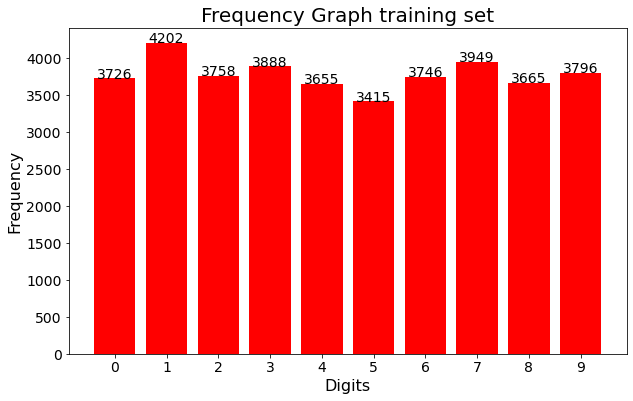

In [13]:
frequency_plot(counts, "Frequency Graph training set")

### 2. Frequency plot for the validation set

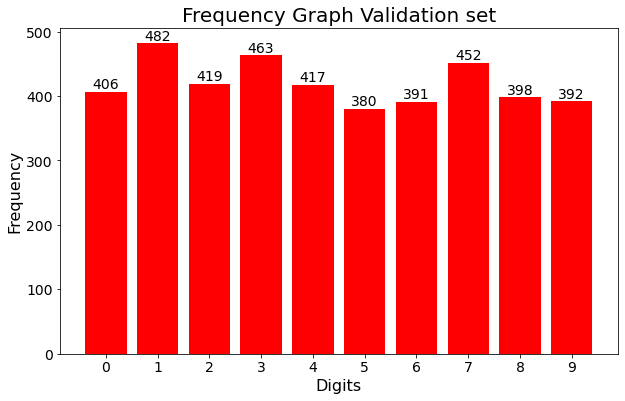

In [15]:
frequency_plot(counts_val, 'Frequency Graph Validation set')

It seems that both the training and validation set has a good balance between the classes, so let's move on and see a few of the digits.

## Visualizing the digits by plotting Images
This will plot the first 30 images of digits with the label.

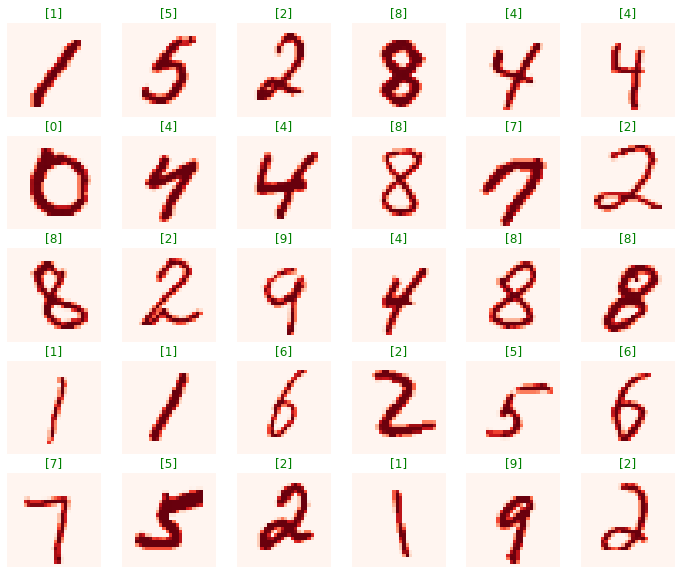

In [16]:
rows = 5
cols = 6

f = plt.figure(figsize=(2 * cols, 2 * rows))

for i in range(rows * cols):
    f.add_subplot(rows, cols, i + 1)
    plt.imshow(train_x[i].reshape([28, 28]), cmap='Reds')
    plt.axis("off")
    plt.title(str(train_y[i]), y=1, color='green')

## Buliding Model

### Model Using Keras
There are two different ways of defining the Model in Keras:

* Sequential Model
* Function API
Functional API is used to build a more complicated Model such as for multi-output Models, directed acyclic graphs, or models with shared layers. I am using the Sequential Model in this notebook to keep things simple.
In Sequential Model, you can add each layer sequentially.

<b>Description of Model:</b>

* 2 Convolutional Blocks
Each block consists of 2 Conv2D layers with LeakyRelU activation layers. Then a MaxPool2D layer and finally a Dropout Layer.

* Then Dense Layers and Output layer after Flatten layer.
* MaxPool2D layer is used to reduce the size of the image. Pool size (2,2) means reducing the image from (28,28) to (14,14). Reducing the features.
* Dropout layer drops the few activation nodes while training, which acts as regularization. Do let the model to over-fit.
* Output layer has 10 nodes with sigmoid activation.

In [17]:
model = models.Sequential()

#Block 1
model.add(Conv2D(32, 3, padding="same", input_shape=(28, 28, 1)))
model.add(LeakyReLU())
model.add(Conv2D(32, 3, padding="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Block 2
model.add(Conv2D(64, 3, padding="same"))
model.add(LeakyReLU())
model.add(Conv2D(64, 3, padding="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

## Compiling Model
Model compilation required the selection of optimizer and loss function. Let me discuss a few important things to avoid confusion.

<b>Optimizers:</b> Keras provides several optimizers that can be used by importing the optimizers and passing in compile function.

* SGD (Stochastic gradient descent optimizer)
* RMSprop
* Adam
* Adamax
There are several more check it out here.

One of the important things is the selection of the learning rate. If the learning rate is too high, the loss may not converge, and if it is too low, the training will be slow. So it is important to select the reasonably fair value of learning rate. One of the good value to start with is 0.001. If it doesn't work, then other higher or lower values can be tried. The rest of the parameters generally works well and need not be defined. The default value works most of the time. Here, I am using Adam optimizer, but RMSprop can also be used.

<b>Loss Functions: </b>Keras provides all of the well-known loss functions which work well for most of the time. But if you need to define a custom loss function, you can. Defining a custom function is out of the scope of this notebook. Let's understand the loss function for the classification tasks. I am discussing 3 loss function here. There are several more check it out here.

* <b>binary_crossentropy:</b> This loss function is used for the binary classification task. The single-node output layer is required. 0 and 1 is used for classification.
* <b>categorical_crossentropy:</b> Used for Used for Multi-class classification
* <b>sparse_categorical_crossentropy:</b> Used for Multi-class classification.
<b>Difference between categorical_crossentropy and sparse_categorical_crossentropy:</b>
* If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings (for three classes):
   *  [1,0,0]
   *  [0,1,0]
   * [0,0,1]
* But if your targets are integers, use sparse_categorical_crossentropy. Examples of integer encodings (for the sake of completion):
  * 1
  * 2
  * 3

Here, I am using sparse_categorical_crossentropy, as the target values are integer not one-hot vector.

In [18]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

## Training
model.fit() is used to train the model. It takes training data, batch_size, no of epochs, validation data. I am taking the epochs = 20 and batch size = 256. It will return the history of training, which later can be used to analyze the performance.

In [19]:
epochs = 20
batch_size = 256
history_1 = model.fit(train_x, train_y, batch_size=batch_size,
                      epochs=epochs, validation_data=[val_x, val_y])

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 161s 4ms/step - loss: 0.4367 - accuracy: 0.8626 - val_loss: 0.1237 - val_accuracy: 0.9643
Epoch 2/20
37800/37800 [==============================] - 145s 4ms/step - loss: 0.0904 - accuracy: 0.9726 - val_loss: 0.0879 - val_accuracy: 0.9729
Epoch 3/20
37800/37800 [==============================] - 146s 4ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.0546 - val_accuracy: 0.9836
Epoch 4/20
37800/37800 [==============================] - 146s 4ms/step - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.0490 - val_accuracy: 0.9855
Epoch 5/20
37800/37800 [==============================] - 148s 4ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.0526 - val_accuracy: 0.9833
Epoch 6/20
37800/37800 [==============================] - 162s 4ms/step - loss: 0.0317 - accuracy: 0.9905 - val_loss: 0.0442 - val_accuracy: 0.9864
Epoch 7/20
37800/37800 [==============================] - 144s 

## Training Performance.
Let's see how the training goes—plotting the accuracy and loss of both training and validation set with each epoch. In the accuracy graphs, there is clearly a difference in the training and validation set. The model is more accurate on the training set. It seems that the model is a little bit overfit. So can we do better?

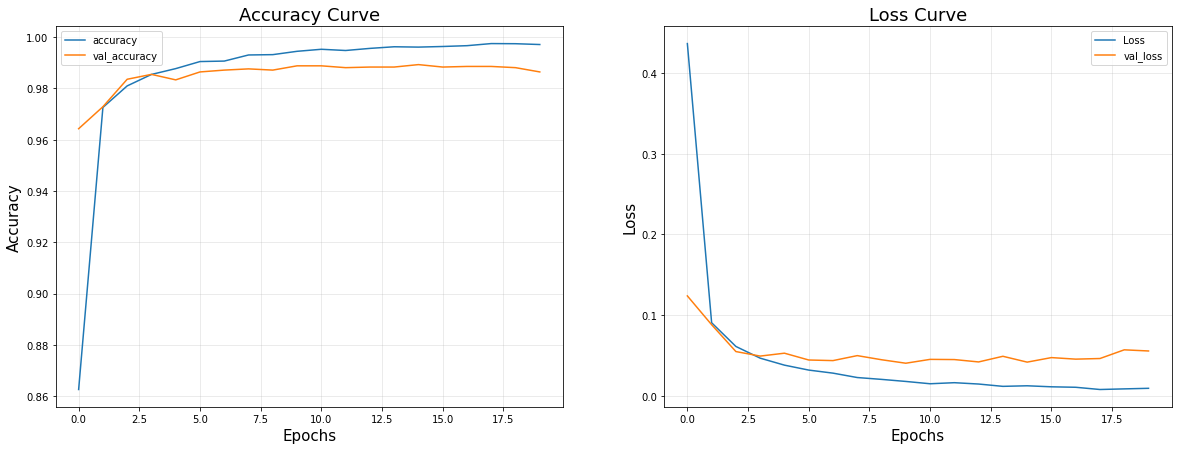

In [20]:
f = plt.figure(figsize=(20, 7))
#Adding subplot 1 (for accuracy)
f.add_subplot(121)

plt.plot(history_1.epoch, history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Adding subplot 2 (for loss)
f.add_subplot(122)

plt.plot(history_1.epoch, history_1.history['loss'], label='Loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], label='val_loss')

plt.title("Loss Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

## Confusion Matrix
In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).

Let's try to see how well the model is performing on the validation set.

In [21]:
val_p = np.argmax(model.predict(val_x), axis=1)
error = 0
confusion_matrix = np.zeros([10, 10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i], val_p[i]] += 1
    if val_y[i] != val_p[i]:
        error += 1
        
print("Confusion Matrix : \n\n", confusion_matrix)
print("\nErrors in validation set: ", error)
print("\nError Percentage: ", (error * 100)/val_p.shape[0])
print("\nAccuracy: ", 100 - (error*100)/val_p.shape[0])
print("\nValidation set shape: ", val_p.shape[0])

Confusion Matrix : 

 [[406.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 479.   0.   0.   0.   1.   0.   2.   0.   0.]
 [  0.   0. 415.   0.   0.   0.   0.   3.   1.   0.]
 [  0.   0.   0. 460.   0.   1.   0.   0.   2.   0.]
 [  2.   0.   2.   0. 398.   0.   4.   1.   2.   8.]
 [  0.   0.   0.   0.   0. 379.   0.   0.   1.   0.]
 [  4.   0.   1.   1.   1.   2. 382.   0.   0.   0.]
 [  0.   0.   2.   0.   0.   0.   0. 449.   0.   1.]
 [  1.   0.   2.   1.   0.   0.   1.   0. 393.   0.]
 [  1.   0.   0.   2.   2.   2.   0.   3.   0. 382.]]

Errors in validation set:  57

Error Percentage:  1.3571428571428572

Accuracy:  98.64285714285714

Validation set shape:  4200


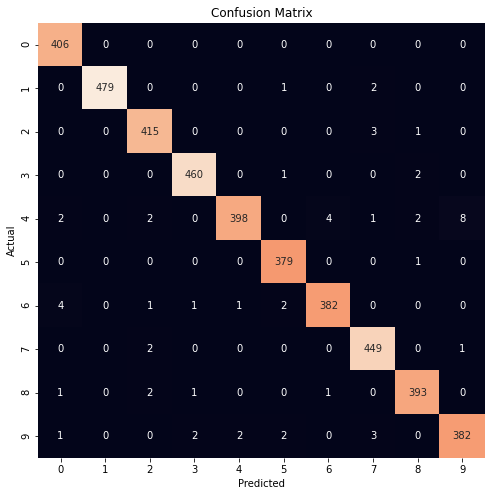

In [23]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cbar=False, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Improving Result by Image Augmentation

A deep network requires extensive data to achieve decent performance. To build a good classifier with small training data, image augmentation can solve the problem to a greater extend. Image augmentation generates images by different ways of processing, such as random shift, rotation, flips, etc.

### Augmentation Using Keras
Here I am using the ImageDataGenerator() function of Keras for Image augmentation. Parameters to use:

* <b>rotation_range:</b> randomly rotate images in the range (degrees, 0 to 180)
* <b>zoom_range:</b> Randomly zoom image
* <b>width_shift_range:</b> randomly shift images horizontally (fraction of total width)
* <b>height_shift_range:</b> randomly shift images vertically (fraction of total height)
* <b>horizontal_flip:</b> randomly flip images (Can't be used in this case as it changes the digit)
* <b>vertical_flip:</b> randomly flip images (Can't be used in this case as it changes the digit)


After the creation and configuration of the ImageDataGenerator, you must fit it on the data, which calculates any statistics required to perform the transformation on the data. This can be done by calling the fit() function on datagen.

In [27]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)

datagen.fit(train_x)

## Learning Rate
ReduceLROnPlateau() is a callback function provided by Keras, which is used to reduce the learning rate if when a metric has stopped improving.



<b>Parameters:</b>

* <b>monitor:</b> takes the metric to observe (In this case val_accuracy)
* <b>patience:</b> waits for that much epochs for the improvements, if not, then decrease the learning rate. (here 2)
* <b>factor:</b> factor by which the learning rate will be reduced. new_lr = lr * factor (here 0.5)
* <b>min_lr:</b> lower bound on the learning rate. (here 0.00001)

In [28]:
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                       verbose=1, factor=0.5, min_lr=0.00001)

## Further Traning
model.fit_generator() is used to train the model on data generated batch-by-batch by image augmentation. The data generator is an iterator that generates and provides data as per request by fit_generator(). We can configure the batch size and get the batches by calling the flow() function.

In [29]:
epochs = 20
history_2 = model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                               steps_per_epoch = int(train_x.shape[0]/batch_size) + 1,
                                epochs = epochs,
                                validation_data = [val_x, val_y],
                                callbacks = [lrr])

Epoch 1/20
148/148 [==============================] - 173s 1s/step - loss: 0.1283 - accuracy: 0.9625 - val_loss: 0.0309 - val_accuracy: 0.9907
Epoch 2/20
148/148 [==============================] - 154s 1s/step - loss: 0.0615 - accuracy: 0.9814 - val_loss: 0.0349 - val_accuracy: 0.9910
Epoch 3/20
148/148 [==============================] - 148s 1s/step - loss: 0.0540 - accuracy: 0.9826 - val_loss: 0.0305 - val_accuracy: 0.9929
Epoch 4/20
148/148 [==============================] - 150s 1s/step - loss: 0.0487 - accuracy: 0.9844 - val_loss: 0.0482 - val_accuracy: 0.9871
Epoch 5/20
148/148 [==============================] - 146s 988ms/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.0202 - val_accuracy: 0.9945
Epoch 6/20
148/148 [==============================] - 151s 1s/step - loss: 0.0382 - accuracy: 0.9882 - val_loss: 0.0248 - val_accuracy: 0.9921
Epoch 7/20
148/148 [==============================] - 146s 984ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.0229 - val_accuracy: 

## Training Performance.
Now we can see that after further training, the accuracy of training and validation set almost converges with high accuracy. It seems that the model has been significantly improved after image augmentation.

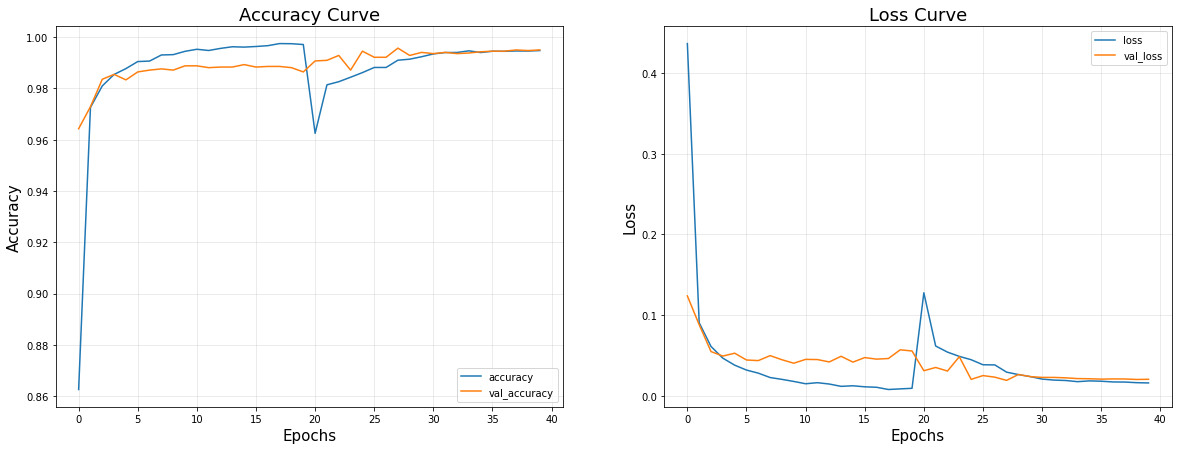

In [30]:
f = plt.figure(figsize=(20, 7))
f.add_subplot(121)

plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),
        history_1.history['accuracy']+history_2.history['accuracy'],
        label = 'accuracy')
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),
                             history_1.history['val_accuracy']+history_2.history['val_accuracy'],
                             label="val_accuracy")
plt.title("Accuracy Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

f.add_subplot(122)

plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),
        history_1.history['loss']+history_2.history['loss'],
        label = 'loss')
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),
                             history_1.history['val_loss']+history_2.history['val_loss'],
                             label="val_loss")
plt.title("Loss Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

## Confusion Matrix

In [31]:
val_p = np.argmax(model.predict(val_x), axis=1)
error = 0
confusion_matrix = np.zeros([10, 10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i], val_p[i]] += 1
    if val_y[i] != val_p[i]:
        error += 1

print("Confusion Matrix: \n\n", confusion_matrix)
print("\nErros in validation set: ", error)
print("\nError Percentage : ", (error*100)/val_p.shape[0])
print("\nAccuracy : ", 100 - (error * 100) / val_p.shape[0])
print("\nValidation set shape : ", val_p.shape[0])

Confusion Matrix: 

 [[406.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 478.   0.   0.   1.   0.   0.   3.   0.   0.]
 [  0.   0. 418.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 461.   0.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   0. 415.   0.   2.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 378.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   1.   0. 389.   0.   1.   0.]
 [  0.   0.   2.   0.   0.   0.   0. 450.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0. 397.   0.]
 [  0.   0.   0.   0.   3.   1.   0.   1.   0. 387.]]

Erros in validation set:  21

Error Percentage :  0.5

Accuracy :  99.5

Validation set shape :  4200


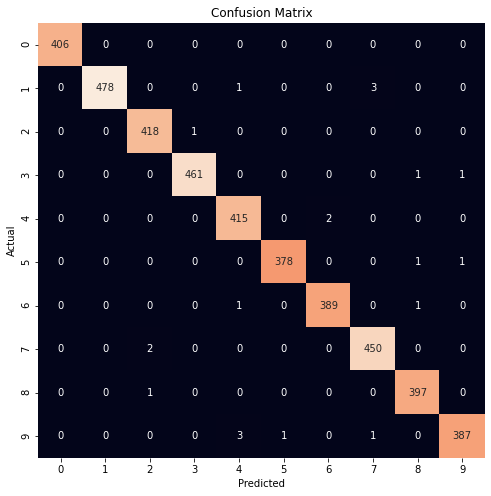

In [32]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cbar=False, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Visualizing Result
All Errors in the Validation set
Let's see all the errors in the validation set. It seems that in most of the cases, the recognition of digits is difficult for even humans. So we can say that our model is performing well.

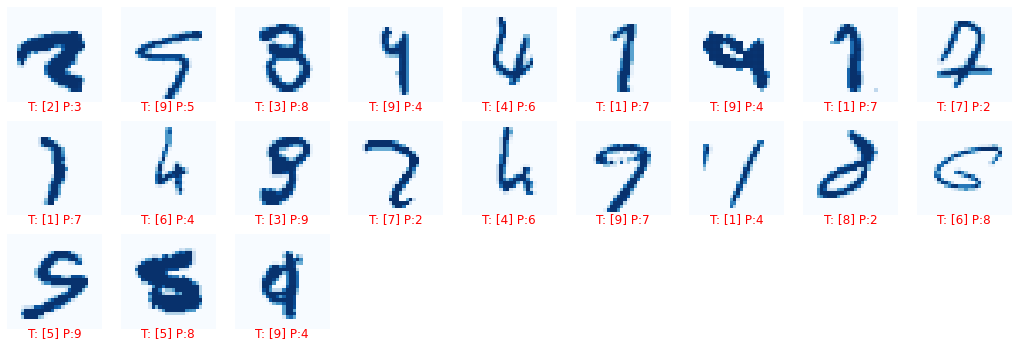

In [33]:
rows = 4
cols = 9

f = plt.figure(figsize=(2*cols, 2*rows))
subplot = 1
for i in range(val_x.shape[0]):
    if val_y[i] != val_p[i]:
        f.add_subplot(rows, cols, subplot)
        subplot += 1
        plt.imshow(val_x[i].reshape([28, 28]), cmap="Blues")
        plt.axis("off")
        plt.title("T: "+str(val_y[i]) + " P:"+str(val_p[i]),
                  y=-0.15, color='Red')
plt.show()

## Predict on Testset

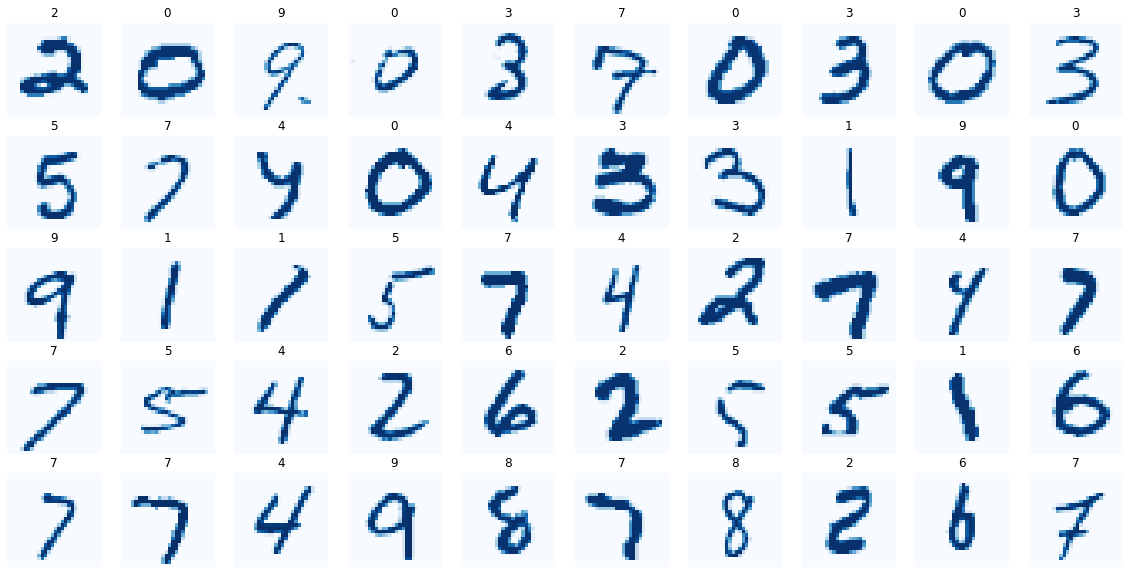

In [34]:
test_y = np.argmax(model.predict(test_x), axis=1)

rows = 5
cols = 10

f = plt.figure(figsize=(2*cols, 2*rows))

for i in range(rows*cols):
    f.add_subplot(rows, cols, i+1)
    plt.imshow(test_x[i].reshape([28, 28]), cmap='Blues')
    plt.axis("off")
    plt.title(str(test_y[i]))

## Lets understand the intermediate layers of the model

To visualize the output of each layer, we need to create a model to take input tensor and gives the list of output tensor, each representing the corresponding intermediate layers. To that, we need to create a multi-output model in which the input will be the image, and the output will be the list of intermediate layers.



I will use the Functional API of Keras to do so. When fed an image input, this model returns the values of the layer activations in the original model.
I am taking all the intermediate layers except the Flatten and Dense layers.

model.layers returns the list of layers of the model. Selecting all the layers except the last four layers. Then passing to models.Model() as a list of output layers and the input layer of the original model. It will return a new model having the input and output layers of the original model.

In [51]:
output_layers = [layer.output for layer in model.layers[:-4]]
activation_model = models.Model(inputs=model.input,
                                outputs=output_layers)

## Try to compare the layer 1 output

In [52]:
activations_2 = activation_model.predict(val_x[2].reshape([1,28,28,1]))
activations_6 = activation_model.predict(val_x[7].reshape([1,28,28,1]))
first_activation_layer = activations_2[0]
first_activation_layer.shape

(1, 28, 28, 32)

activation_2 and activation_6 are the output of two different images. first_activation_layer represents the output of the first layer of the original model. The shape is (1,28,28,32) where 32 represent the number of channels. Let's compare the four different channels of the first layer of two different images.

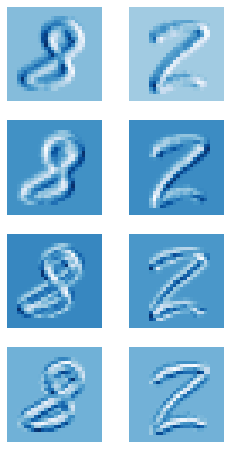

In [53]:
rows = 4
cols = 2

f = plt.figure(figsize=(2*cols, 2*rows))

for i in range(4):
    f.add_subplot(rows, cols, 2*i+1)
    plt.imshow(activations_2[0][0,:,:,i].reshape([28,28]), cmap="Blues")
    plt.axis("off")
    
    f.add_subplot(rows, cols, 2*i+2)
    plt.imshow(activations_6[0][0,:,:,i].reshape([28,28]), cmap="Blues")
    plt.axis("off")

It seems that each channel is trying to depict something in both images, a kind of similar features. This can be concluded that each channel has been trained to find some specific features of the input images.

## Visualizing All Intermediate Activation Layer


In [54]:
def plot_layer(layer, i, layer_name=None):
    rows = layer.shape[-1]/16
    cols = 16
    
    f = plt.figure(figsize=(1*cols, 1*rows))
    for i in range(layer.shape[-1]):
        f.add_subplot(rows, cols, i+1)
        plt.imshow(layer[0,:,:,i].reshape([layer.shape[2], layer.shape[2]]), cmap='Blues')
        plt.axis("off")
    f.suptitle(layer_name, fontsize=14)
    plt.show()

C:\Users\Bhavesh kumar\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


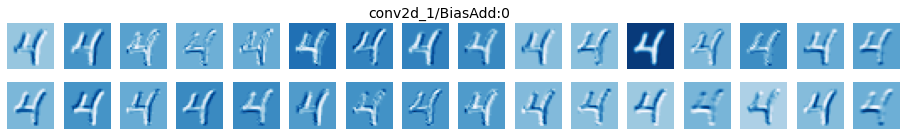

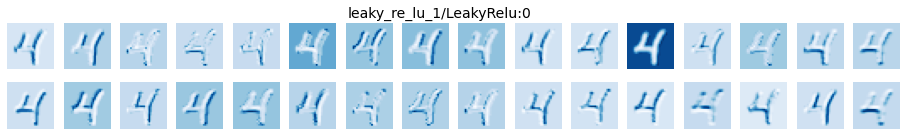

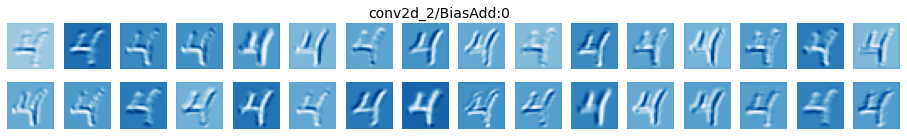

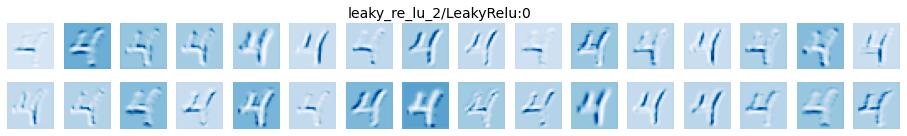

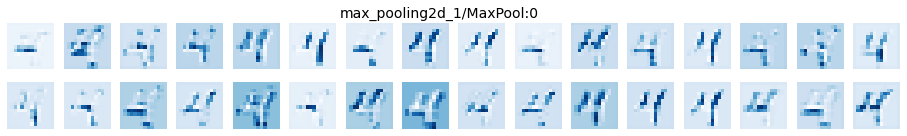

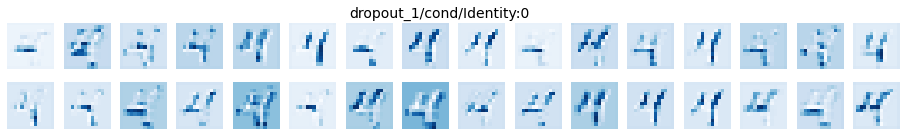

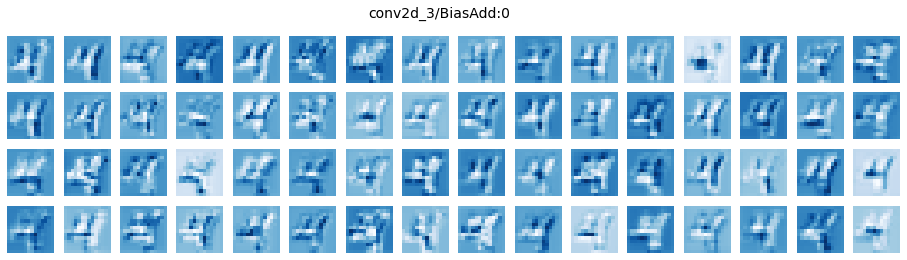

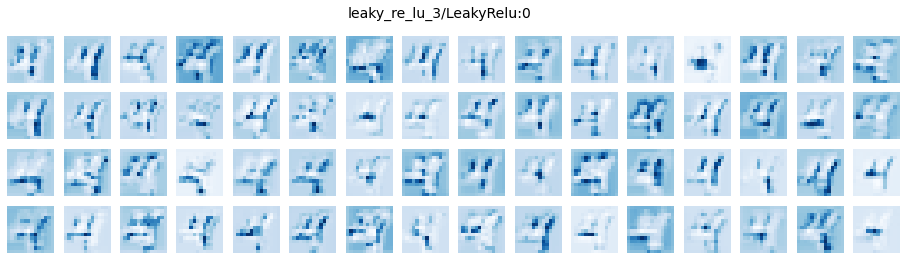

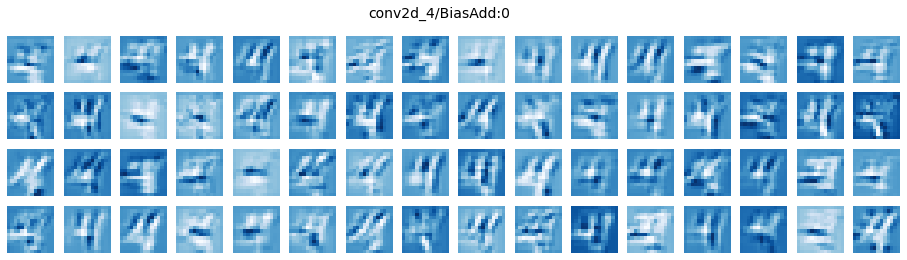

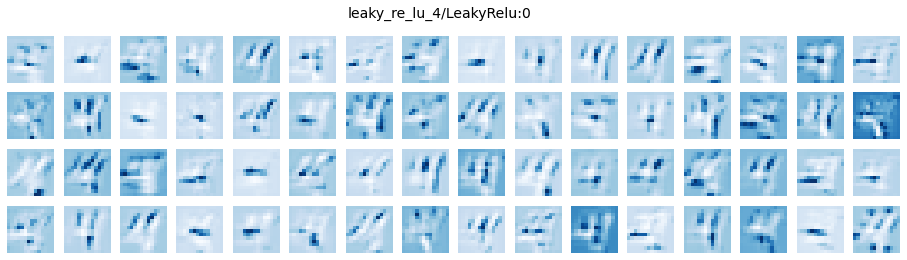

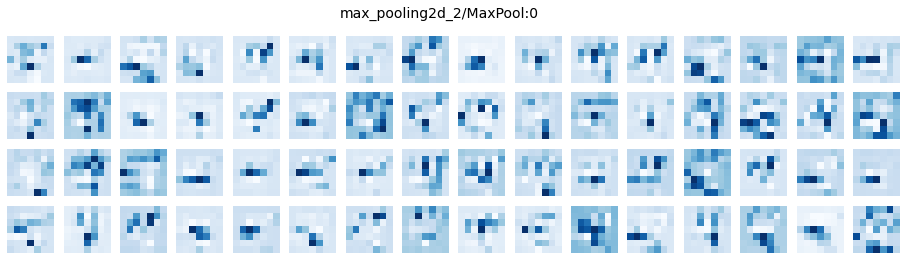

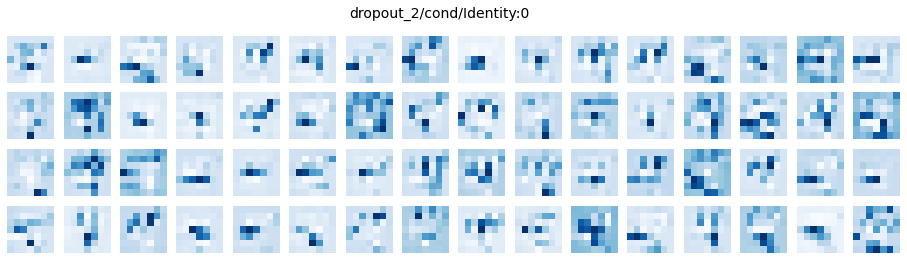

In [55]:
for i, layer in enumerate(activation_model.predict(val_x[6].reshape([1, 28, 28, 1]))):
    plot_layer(layer, i, output_layers[i].name)

So, try to understand what's happening inside the hidden layers:

* The first few layers retaining the shape of image but trying to get the very low-level features such as different types edges.
* As we go into the deeper layers, the activations are more abstract and less visually interpretable. These layers are trying to encode high-level features such as corners, angles, selective borders, etc.
* In the last few layers, We can't visually interpret anything; this is because layers are now encoding even more complex features, or we can say more information about the classes.
I hope you understand the basics of CNN after the visualization of intermediate layers even more.

In [56]:
df_submission = pd.DataFrame([df_test.index+1, test_y],
                            ['ImageId', 'Label']).transpose()
df_submission.to_csv("submission.csv", index=False)